In [3]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import loaders
import extract_uses.utils as utils

city_ref = 'grenoble'
activities_shp = "../grenoble/full_activities_pts.shp"

bbox = utils.getBoundingBox(activities_shp)
print(bbox)

geo_graph = loaders.load_graph(city_ref, bbox)
pois_df = loaders.load_extracted_osm_pois(activities_shp)
centrality_df = loaders.load_centrality(city_ref, geo_graph)
kde_df = loaders.load_kde(city_ref, geo_graph, pois_df)

('Bounding box:', [5.5764359, 45.11334367251151, 5.9025706, 45.24389538600425])
[5.5764359, 45.11334367251151, 5.9025706, 45.24389538600425]
Querying locally for `['nodes', 'edges']`
Found ['nodes', 'edges'] stored locally
Querying locally for `['centrality']`
Found ['centrality'] stored locally
Querying locally for `['kde']`
Found ['kde'] stored locally


In [9]:
pois_df.head()

"""
TODO: Map [key,value] to category classification

import extract_uses.classif_uses as classif_uses

# Map every key,value to its final Key category
# landuse => commercial/industrial
pois_df[ pois_df['key'] == "landuse" & pois_df['value'].isin(classif_uses.landuse_activities)]
#['key'] = 'commercial'
"""


'\nTODO: Map [key,value] to category classification\n\nimport extract_uses.classif_uses as classif_uses\n\n# Map every key,value to its final Key category\n# landuse => commercial/industrial\npois_df[ pois_df[\'key\'] == "landuse" & pois_df[\'value\'].isin(classif_uses.landuse_activities)]\n#[\'key\'] = \'commercial\'\n'

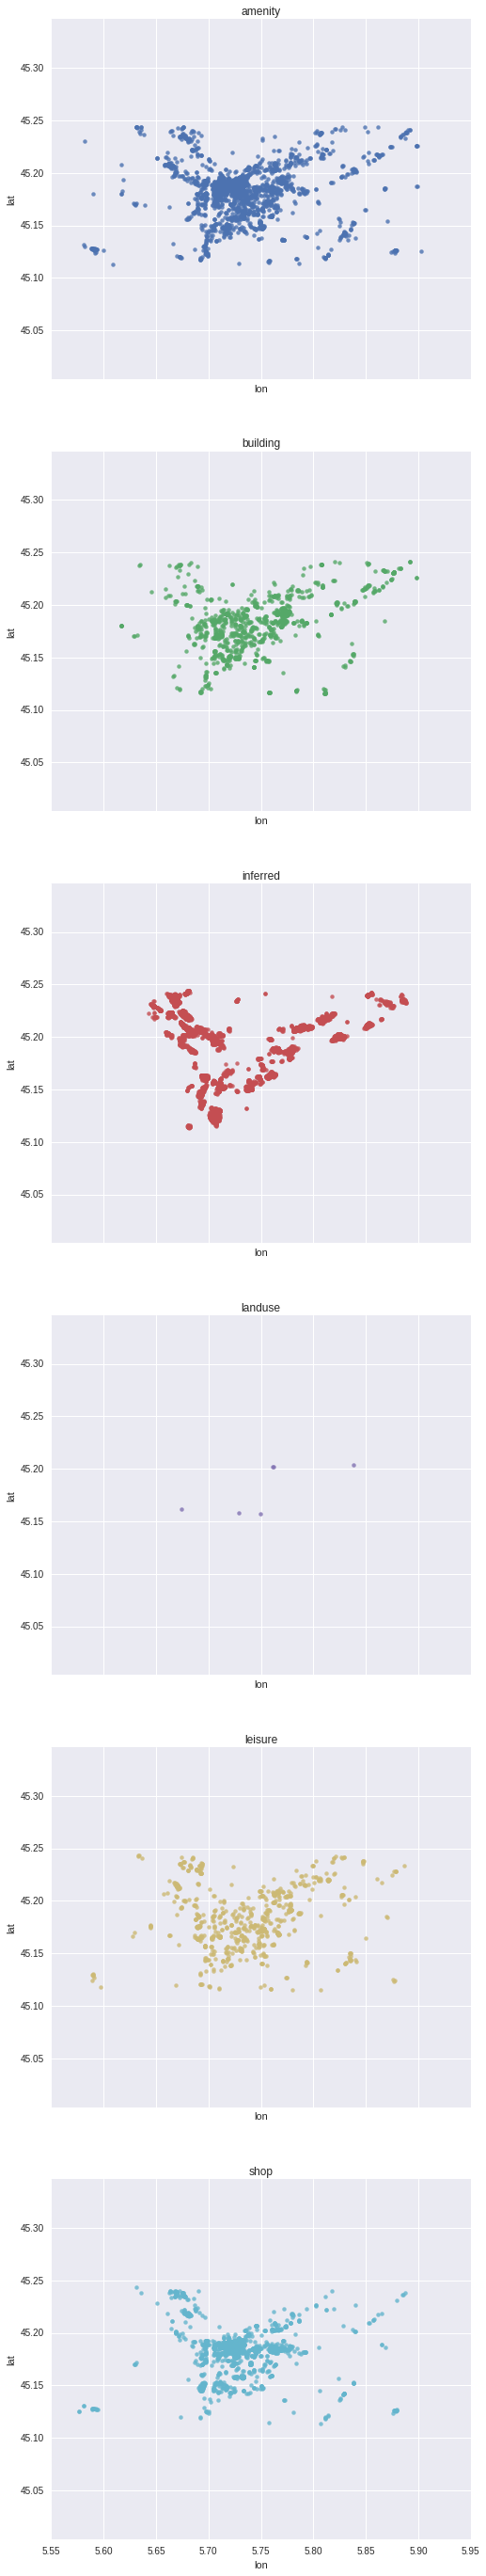

In [10]:
import plots

%matplotlib inline
plots.pois_scatter(pois_df)

In [11]:
kde_df.head()

,amenity,building,leisure,shop
1409886896,-1.839310,-1.839343,-1.839301,-1.839098
1108657,-1.839463,-1.839530,-1.839431,-1.839205
482312237,-1.839037,-1.838945,-1.839220,-1.838871
321355830,-1.842337,-1.841669,-1.843492,-1.842298
1106575417,-1.839008,-1.838913,-1.839302,-1.838726


In [12]:
import pandas as pd

# TODO: automatize this in some module

centrality_kde_df = pd.concat([
    pd.DataFrame({ key: value for (key, value) in zip(kde_df.columns, list(map(kde_df.__getitem__, kde_df.columns))) }),
    centrality_df], axis=1, keys=['kde', 'centrality'])
centrality_kde_df.head()

kde                                centrality                    
         amenity  building   leisure      shop betweenness closeness    degree
124550 -1.838512 -1.838382 -1.838814 -1.838294    0.000000  0.013931  0.000239
124551 -1.838493 -1.838355 -1.838810 -1.838277    0.000062  0.013977  0.000358
124552 -1.838490 -1.838349 -1.838809 -1.838277    0.003265  0.014027  0.000358
124553 -1.838506 -1.838373 -1.838812 -1.838292    0.000541  0.014235  0.000358
124554 -1.838704 -1.838637 -1.838895 -1.838479    0.003268  0.015433  0.000358

In [13]:
# TODO: automatize this in some module
centrality_kde_corr = centrality_kde_df.corr().xs('kde', level=0).xs('centrality', level=0, axis=1)
centrality_kde_corr

,betweenness,closeness,degree
amenity,0.157639,0.629709,0.204715
building,0.158290,0.614150,0.200775
leisure,0.151903,0.630852,0.203295
shop,0.155893,0.630623,0.204884


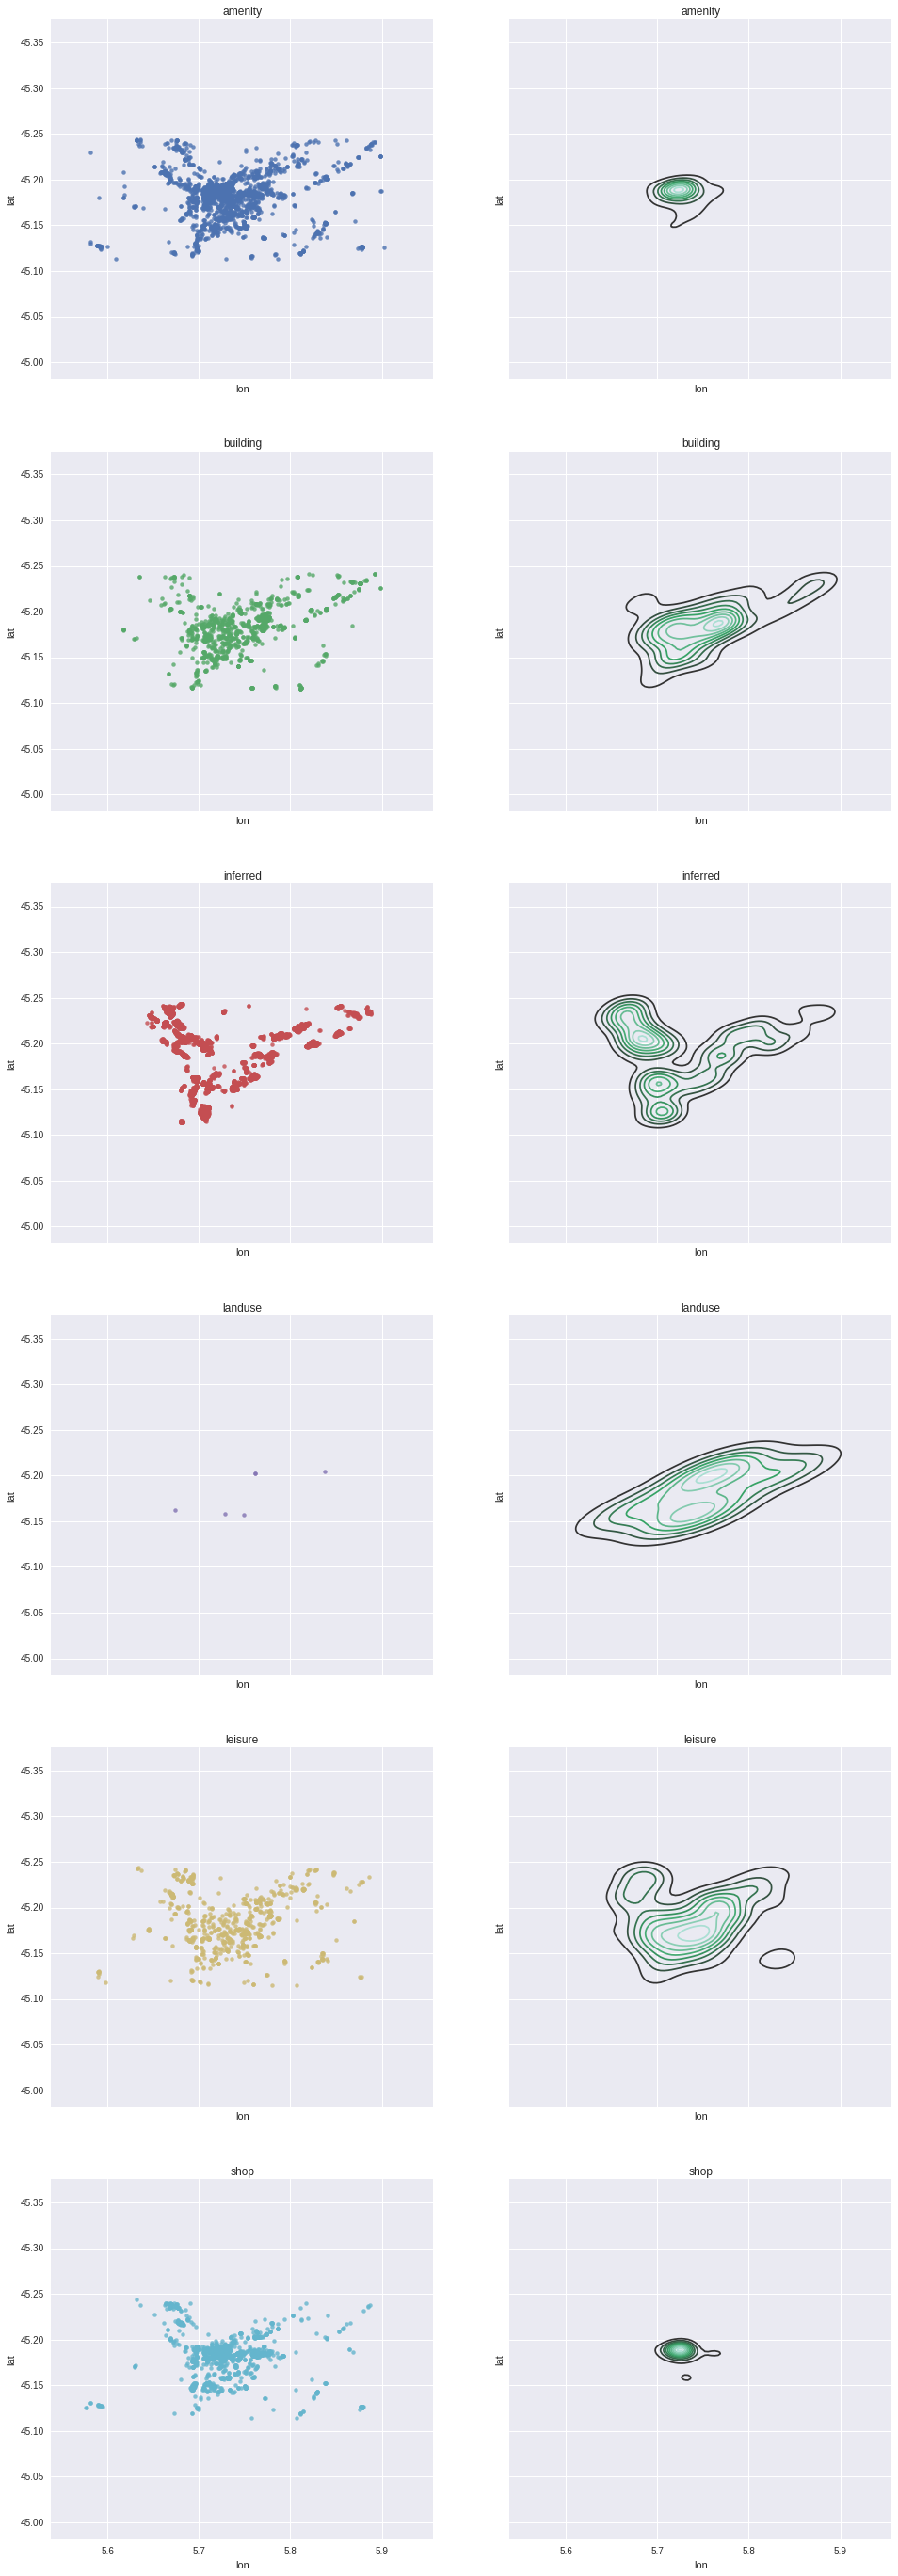

In [14]:
plots.pois_scatter_kde(pois_df, kde_df)

In [9]:
# TODO: create method for this in plots.py
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib qt

cmap = plt.get_cmap('jet')

for centrality_label in centrality_df:
    for category_label, category_ser in pois_df.groupby(by=['key']):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title(centrality_label + ' vs ' + category_label)
        sns.kdeplot(category_ser['lon'], category_ser['lat'], ax=ax, legend=True, shade=True)
        geo_graph.plot(ax, node_color = [centrality_df[centrality_label][node.id] for node in geo_graph], node_size=20, cmap=cmap) # TODO: maybe hide edges